In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pandas
import datetime as dt

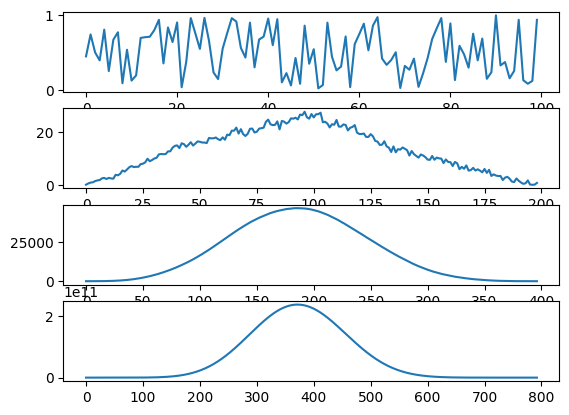

In [2]:
# Generating a random vector and applying convolution with itself.
fig, axs = plt.subplots(4)

v = np.random.random(100)
axs[0].plot(v)

for i in range(3):
    v = np.convolve(v, v)
    axs[i+1].plot(v)

In [13]:
# Multiplying two polinomials using fft. 

def poly_to_string(p):
    result = str(p[0]) 

    for (i, k) in enumerate(p[1:]):
        result += f" + {str(k)}x^{str(i+1)}"
    return result

n =  5

p = np.random.randint(size = n+1, low = 1, high= 5)
q = np.random.randint(size= n+1, low = 1, high= 5)

print("p = ", poly_to_string(p))
print("q = ", poly_to_string(q))

# First try using naive convolution.
result_convolve = np.convolve(p ,q)
print("p * q = ",poly_to_string(result_convolve))

# Then try using fft.
p_freq = np.fft.fft(np.append(p, np.zeros(n)))
q_freq = np.fft.fft(np.append(q, np.zeros(n))) 
pq_freq = p_freq * q_freq
result_fft = np.round(np.fft.ifft(pq_freq).real, 0)

print("p * q = ",poly_to_string(result_fft))

p =  3 + 3x^1 + 4x^2 + 4x^3 + 3x^4 + 1x^5
q =  2 + 4x^1 + 2x^2 + 2x^3 + 3x^4 + 4x^5
p * q =  6 + 18x^1 + 26x^2 + 36x^3 + 45x^4 + 51x^5 + 42x^6 + 36x^7 + 27x^8 + 15x^9 + 4x^10
p * q =  6.0 + 18.0x^1 + 26.0x^2 + 36.0x^3 + 45.0x^4 + 51.0x^5 + 42.0x^6 + 36.0x^7 + 27.0x^8 + 15.0x^9 + 4.0x^10


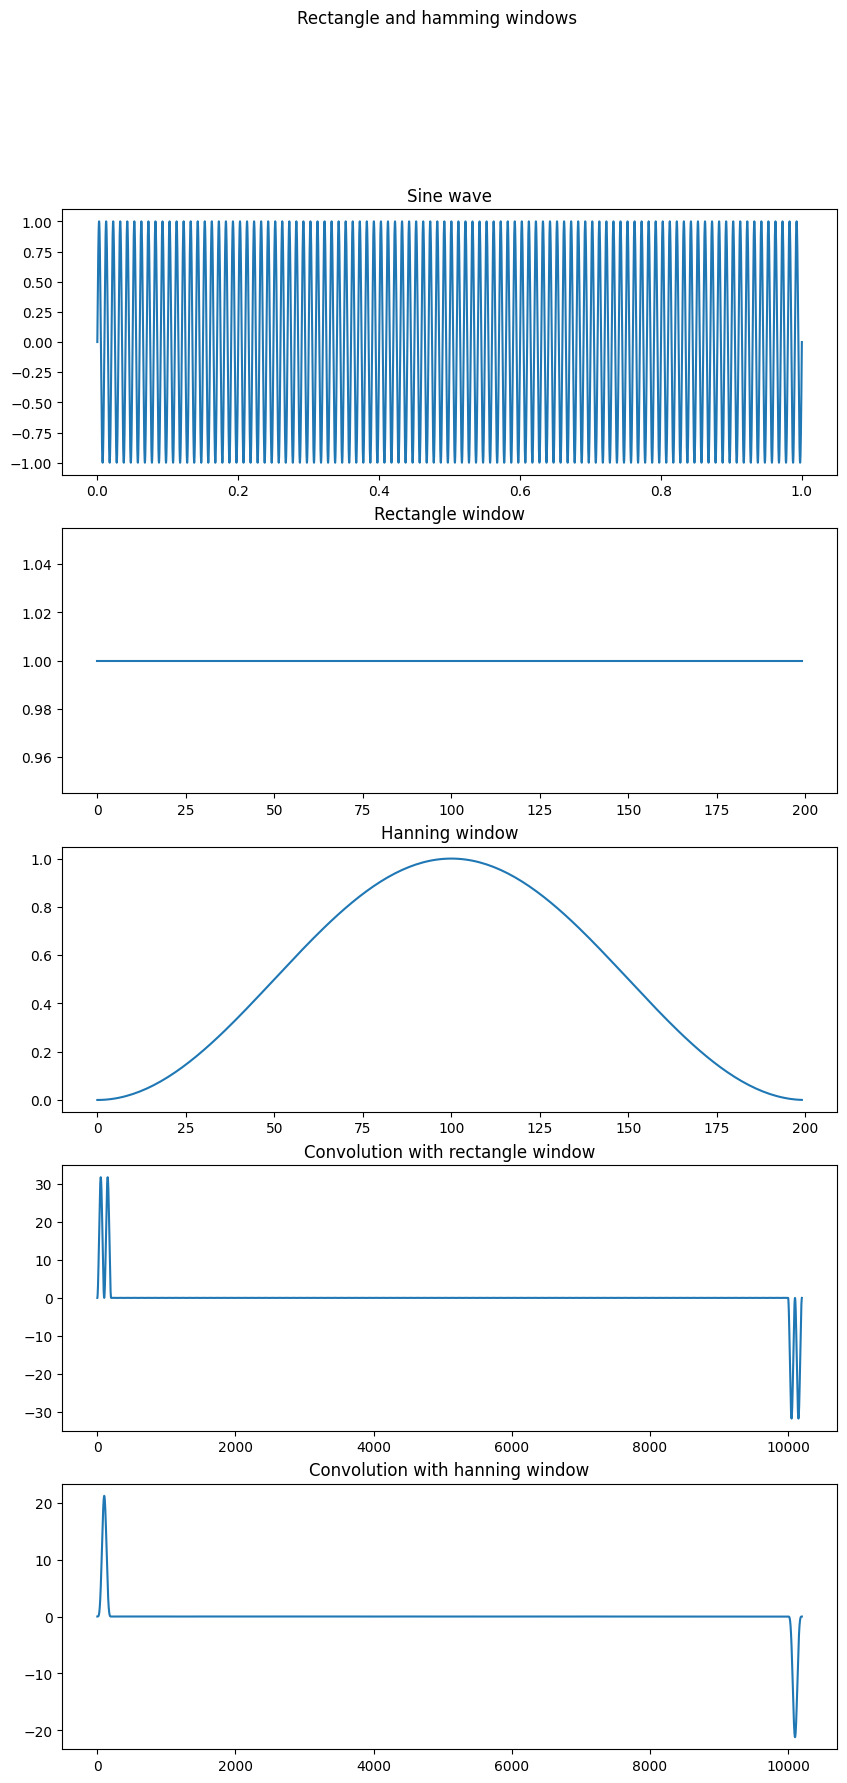

In [14]:
# Using hamming and rectangle windows over a sine signal.

def get_rectangle(n):
    return np.ones(n)

def get_hanning(n):
    values = 2*np.pi *  np.arange(0, n, 1) / n
    return 0.5 * (1- np.cos(values))

fig, axs = plt.subplots(5, figsize=(10,20))
fig.suptitle("Rectangle and hamming windows")

f = 100
sine_wave = lambda t: np.sin(2 * np.pi * t * 100) 
time = np.linspace(0, 1,  10000)

axs[0].set_title("Sine wave")
axs[0].plot(time, sine_wave(time))
axs[1].set_title("Rectangle window")
axs[1].plot(get_rectangle(200))
axs[2].set_title("Hanning window")
axs[2].plot(get_hanning(200))
axs[3].set_title("Convolution with rectangle window")
axs[3].plot(np.convolve(sine_wave(time), get_rectangle(200)))
axs[4].set_title("Convolution with hanning window")
axs[4].plot(np.convolve(sine_wave(time), get_hanning(200)))


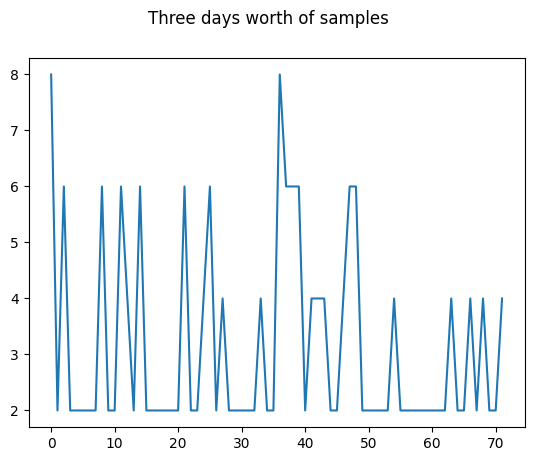

In [15]:
# Sampling three days worth of data.
fig, axs = plt.subplots(1)
fig.suptitle("Three days worth of samples")
x = pandas.read_csv("Train.csv")

start = 0 
per_day = 24
x = x[start:start+3*per_day] 

samples = x["Count"]
axs.plot(samples)

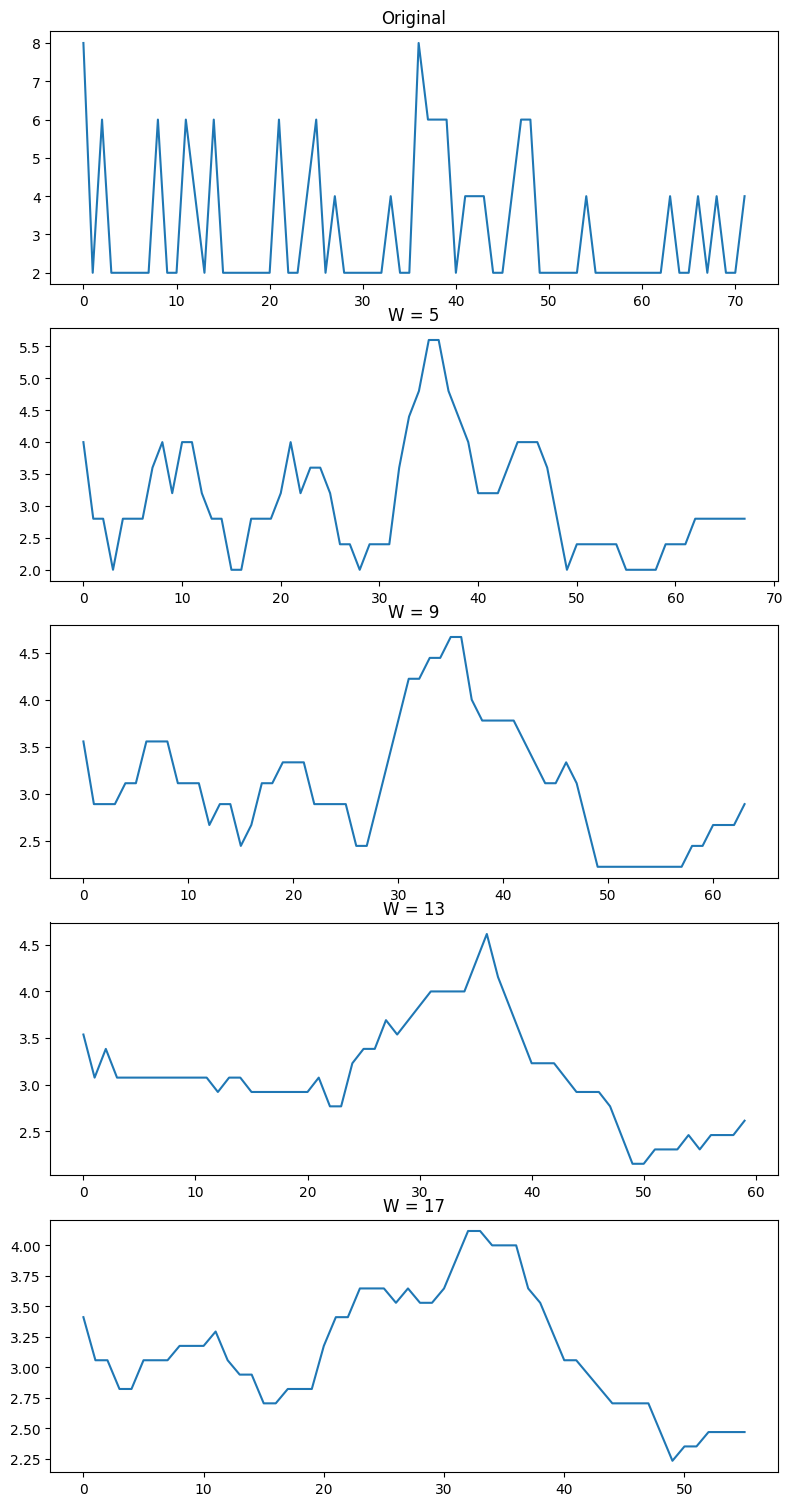

In [18]:
# Passing the signal through a mean-filter.
fig, axs = plt.subplots(5, figsize=(8,15))
fig.tight_layout()

axs[0].set_title("Original")
axs[0].plot(samples)

ws = [5, 9, 13, 17]
for i,w in enumerate(ws):
    axs[i+1].set_title(f"W = {w}")
    window = np.ones(w) / w

    axs[i+1].plot(np.convolve(samples, window, 'valid'))



In [23]:
# Choosing which frequencies we are going to filter. 

# First compute the sampling frequency.
N = len(samples)

date_format = "%d-%m-%Y %H:%M"
first_date = dt.datetime.strptime(x["Datetime"][start], date_format)
last_date = dt.datetime.strptime(x["Datetime"][start+N-1], date_format)

interval = ((last_date-first_date).days + 1) * 24 * 3600
frequency = N/interval
print(f"The frequency is {frequency}")

# The niquist frequency is half the sampling frequency.
nyquist_frequency = frequency/2
print("The nyquist frequency is ", nyquist_frequency)

# Cut from
cut_frequency = 0.00007
nyquist_normalised = cut_frequency/nyquist_frequency
print(nyquist_normalised)


The frequency is 0.0002777777777777778
The nyquist frequency is  0.0001388888888888889
0.504


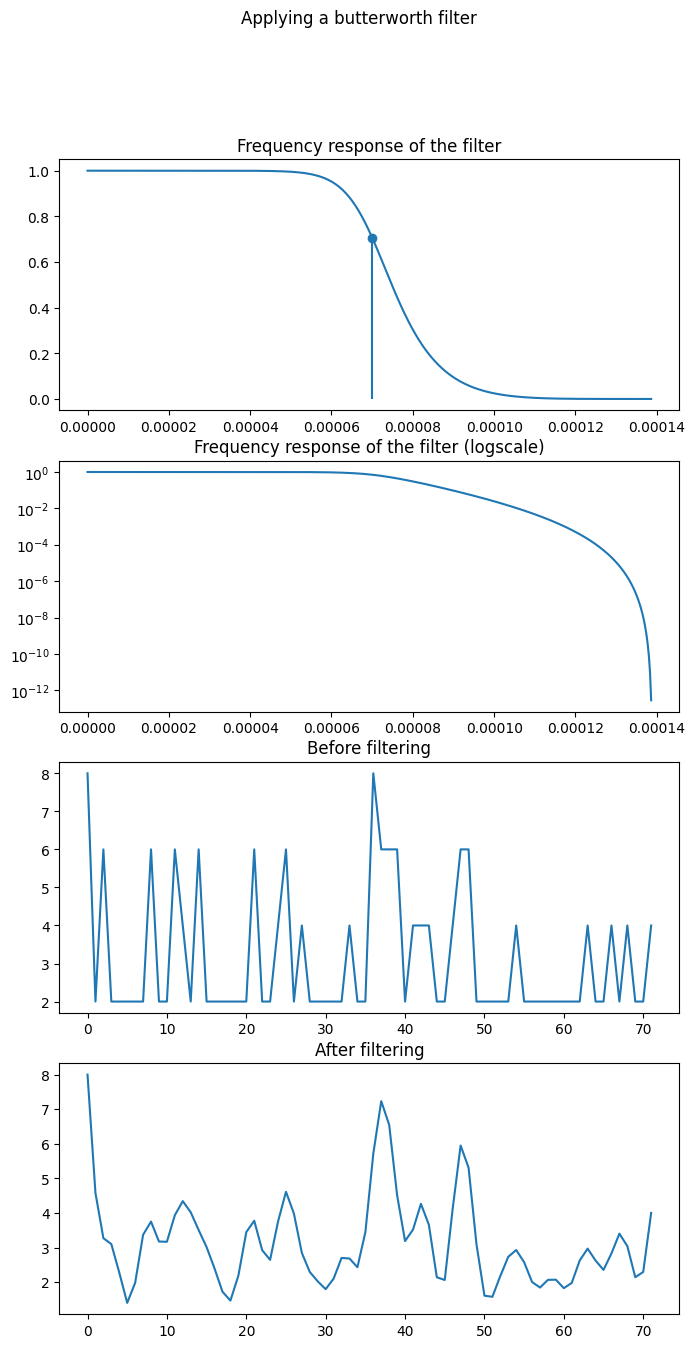

In [42]:
# Butterworth filter
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle("Applying a butterworth filter")

(b, a)= scipy.signal.butter(5, cut_frequency, fs=frequency,btype="lowpass")
w, h = scipy.signal.freqz(b, a, fs=frequency)
_, cut = scipy.signal.freqz(b, a, fs=frequency, worN= [cut_frequency] )

axs[0].set_title("Frequency response of the filter")
axs[0].plot(w, abs(h))
axs[0].stem([cut_frequency], [abs(cut)])

axs[1].set_title("Frequency response of the filter (logscale)")
axs[1].plot(w, abs(h))
axs[1].set_yscale("log")

axs[2].set_title("Before filtering")
axs[2].plot(samples)

axs[3].set_title("After filtering")
filtered = scipy.signal.filtfilt(b, a, samples)
axs[3].plot(filtered)

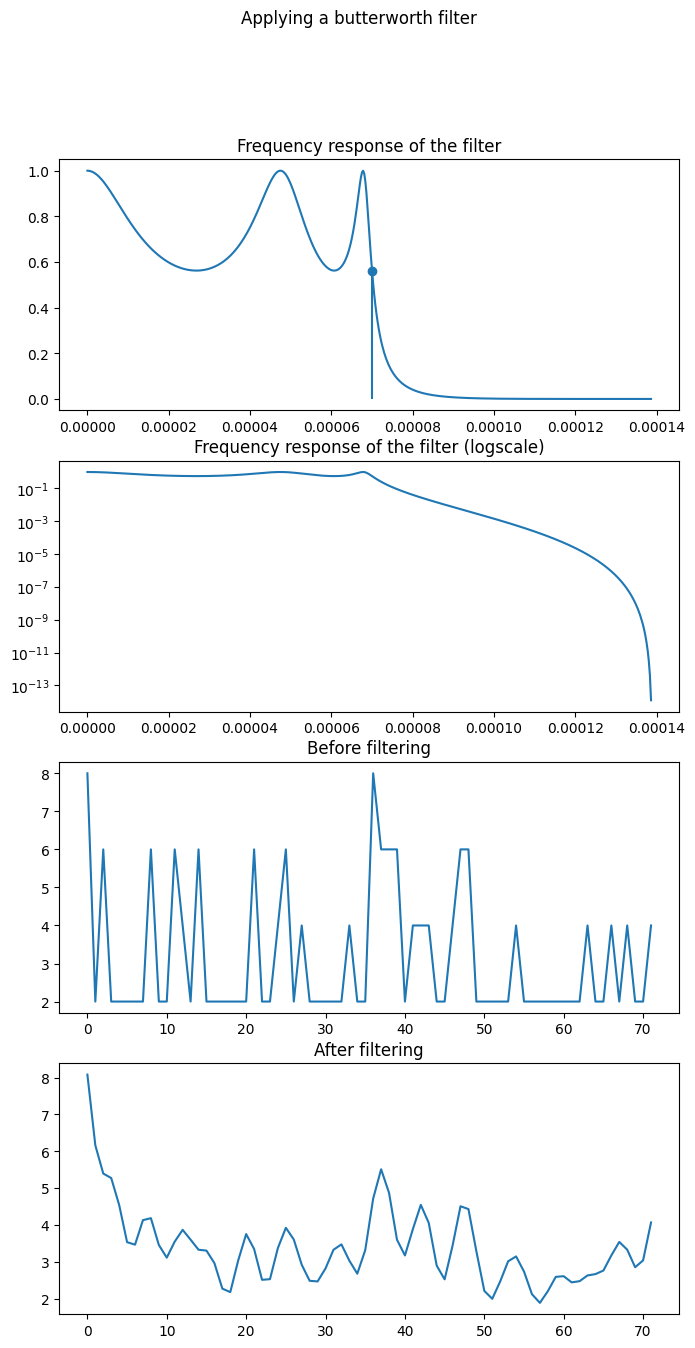

In [48]:
# Chebyshev filter
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle("Applying a butterworth filter")

rp =  5 
(b, a)= scipy.signal.cheby1(5, rp, cut_frequency, fs=frequency,btype="lowpass")
w, h = scipy.signal.freqz(b, a, fs=frequency)
_, cut = scipy.signal.freqz(b, a, fs=frequency, worN= [cut_frequency] )

axs[0].set_title("Frequency response of the filter")
axs[0].plot(w, abs(h))
axs[0].stem([cut_frequency], [abs(cut)])

axs[1].set_title("Frequency response of the filter (logscale)")
axs[1].plot(w, abs(h))
axs[1].set_yscale("log")

axs[2].set_title("Before filtering")
axs[2].plot(samples)

axs[3].set_title("After filtering")
filtered = scipy.signal.filtfilt(b, a, samples)
axs[3].plot(filtered)